In [1]:
# Loading the Packages
%reload_ext autoreload
%autoreload 2

# basic packages
import warnings
warnings.filterwarnings('ignore')
import os
import sys
from pathlib import Path
from tqdm import tqdm

# data processing packages
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
from collections import defaultdict
from glmpca import glmpca
from itertools import combinations
import math

# gaston related packages
import torch
from importlib import reload
import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, restrict_spots, model_selection
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts, parse_adata
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",      # 使用 XeLaTeX，如果不需要 LaTeX 公式渲染，可以省略
    'font.family': 'serif',          # 字体设置为衬线字体
    'text.usetex': False,            # 禁用 LaTeX，使用 Matplotlib 内置文字渲染
    'pgf.rcfonts': False,            # 禁用 pgf 的默认字体管理
    'pdf.fonttype': 42,              # 确保字体为 TrueType 格式，可被 Illustrator 编辑
    'ps.fonttype': 42,               # EPS 文件也使用 TrueType 格式
    'figure.dpi': 300,               # 设置图形分辨率
    'savefig.dpi': 300,              # 保存的图形文件分辨率
    'axes.unicode_minus': False,     # 避免负号问题
})

In [2]:
if torch.cuda.is_available(): torch.set_default_device('cuda')
else: torch.set_default_device('cpu')
print("Default device:", torch.tensor([1.0]).device)

Default device: cuda:0


In [3]:
# workdir 
BASE_DIR = Path(r'G:\spatial_data\analysis')
RUN_ID = '20250222_combined_analysis_of_pseudo_HCC3D'

# Load one slide exp
base_path = BASE_DIR / f'{RUN_ID}'
seg_path = base_path / "segmented"
typ_path = base_path / "cell_typing"
output_path = base_path / "GASTON" / 'pc25_pnty1.5'
output_path.mkdir(exist_ok=True)

## preprocess

In [10]:
# Load the data
adata_direct = sc.read_h5ad(typ_path / 'adata.h5ad')
combine_adata_st = sc.read_h5ad(typ_path / 'combine_adata_st.h5ad')
adata = adata_direct[adata_direct.obs.index.isin(combine_adata_st.obs.index)]
adata.obs = combine_adata_st.obs

# format for later analysis
adata.obs = adata.obs.rename(columns={'X_pos':'X', 'Y_pos':'Y'})
combine_adata_st.obsm['spatial3d'] = np.array([combine_adata_st.obs.X_pos, 
                                               combine_adata_st.obs.Y_pos,
                                               [_*10/0.1625 for _ in combine_adata_st.obs.slice]]).T
adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y']].values
adata.obs['batch'] = adata.obs['dataset']
adata = adata[adata.obs['type'] != 'other']
print(adata)
adata.obs.head()

View of AnnData object with n_obs × n_vars = 1218279 × 31
    obs: 'dataset', 'slice', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'type', 'leiden', 'sample', 'tissue', 'leiden_res=4', 'leiden_res=8', 'leiden_res=5', 'leiden_res=6', 'leiden_res=7', 'tmp_leiden', 'leiden_subtype', 'subtype', 'leiden_type', 'Y', 'X', 'region', 'ROI', 'batch'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


dataset slice  n_genes_by_counts  log1p_n_genes_by_counts  \
3-1   PRISM_HCC     1                  7                 2.079442   
6-1   PRISM_HCC     1                 12                 2.564949   
12-1  PRISM_HCC     1                  7                 2.079442   
15-1  PRISM_HCC     1                  6                 1.945910   
16-1  PRISM_HCC     1                  8                 2.197225   

      total_counts  log1p_total_counts  n_genes  n_counts  type leiden  ...  \
3-1            9.0            2.302585        7       9.0  CD4+     18  ...   
6-1           20.0            3.044522       12      20.0  CD4+      3  ...   
12-1          11.0            2.484907        7      11.0  CD4+      3  ...   
15-1           7.0            2.079442        6       7.0  CD4+      3  ...   
16-1          18.0            2.944439        8      18.0  Mait      2  ...   

     leiden_res=7 tmp_leiden leiden_subtype          subtype leiden_type  \
3-1            14         19             19   T_CD4+, CTLA4+          11   
6-1             0          4             20  T_CD4+, CXCL13+          11   
12-1           85         61             20  T_CD4+, CXCL13+          11   
15-1          129         27             20  T_CD4+, CXCL13+          11   
16-1           40         40             10    Mait_SLC4A10+           6   

               Y             X region    ROI      batch  
3-1   600.279200  26378.435020  other  other  PRISM_HCC  
6-1   670.271470  25614.760921  other  other  PRISM_HCC  
12-1  710.849615  25682.656401  other  other  PRISM_HCC  
15-1  745.758777  26846.669260  other  other  PRISM_HCC  
16-1  799.203877  25874.766723  other  other  PRISM_HCC  

[5 rows x 26 columns]

In [11]:
counts_mat = np.array(adata.raw.X)
coords_mat = adata.obsm['spatial']
cell_types = adata.obs.subtype.values
gene_labels = np.array(adata.var.index)

## run GLM-PCA

In [12]:
# GLM-PCA parameters
num_dims = 25
penalty = 1.5

# CHANGE THESE PARAMETERS TO REDUCE RUNTIME
num_iters = 30
eps = 1e-4
num_genes = 10000

counts_mat_glmpca = counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
glmpca_res = glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
                        ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

Iteration: 0 | deviance=4.7871E+7
Iteration: 1 | deviance=4.7869E+7
Iteration: 2 | deviance=2.1346E+7
Iteration: 3 | deviance=1.0431E+7
Iteration: 4 | deviance=6.5483E+6
Iteration: 5 | deviance=4.6973E+6
Iteration: 6 | deviance=3.6275E+6
Iteration: 7 | deviance=2.9440E+6
Iteration: 8 | deviance=2.4759E+6
Iteration: 9 | deviance=2.1385E+6
Iteration: 10 | deviance=1.8859E+6
Iteration: 11 | deviance=1.6912E+6
Iteration: 12 | deviance=1.5373E+6
Iteration: 13 | deviance=1.4132E+6
Iteration: 14 | deviance=1.3112E+6
Iteration: 15 | deviance=1.2262E+6
Iteration: 16 | deviance=1.1544E+6
Iteration: 17 | deviance=1.0928E+6
Iteration: 18 | deviance=1.0396E+6
Iteration: 19 | deviance=9.9319E+5
Iteration: 20 | deviance=9.5228E+5
Iteration: 21 | deviance=9.1598E+5
Iteration: 22 | deviance=8.8354E+5
Iteration: 23 | deviance=8.5436E+5
Iteration: 24 | deviance=8.2797E+5
Iteration: 25 | deviance=8.0398E+5
Iteration: 26 | deviance=7.8206E+5
Iteration: 27 | deviance=7.6194E+5
Iteration: 28 | deviance=7.434

In [13]:
np.save(output_path / 'glmpca.npy', A)
np.save(output_path / 'coords_mat.npy', coords_mat)
np.save(output_path / 'cell_labels.npy', cell_types)
np.save(output_path / 'counts_mat.npy', counts_mat)
np.save(output_path / 'gene_labels.npy', gene_labels)

In [14]:
# visualize top GLM-PCs
R = 5
C = 5
fig,axs=plt.subplots(R, C, figsize=(C * 5, R * 5))
for r in range(R):
    for c in range(C):
        i = r * C + c
        axs[r, c].scatter(-1 * coords_mat[:, 0], coords_mat[:, 1], c=A[:, i], cmap='Reds', s=1)
        axs[r, c].set_title(f'GLM-PC{i}')
plt.savefig(output_path/'glmpca.png')
plt.close()

## Train GASTON network

In [15]:
# Load data generated above
path_to_coords = output_path / 'coords_mat.npy'
path_to_glmpca = output_path / 'glmpca.npy'

A = np.load(path_to_glmpca)
S = np.load(path_to_coords)

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S, A)

###################################### 
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch = [20, 20]  # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch = [20, 20]  # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 200000  # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500  # save model after number of epochs = multiple of checkpoint
out_dir = output_path / 'model'  # folder to save model runs
optimizer = "adam"
num_restarts = 30

######################################

seed_list = range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed = f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    
    # Move model to GPU
    mod, loss_list = neural_net.train(
        S_torch, A_torch,
        S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
        epochs=num_epochs, checkpoint=checkpoint, 
        save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 0
training neural network for seed 1
training neural network for seed 2
training neural network for seed 3
training neural network for seed 4
training neural network for seed 5
training neural network for seed 6
training neural network for seed 7
training neural network for seed 8
training neural network for seed 9
training neural network for seed 10
training neural network for seed 11
training neural network for seed 12
training neural network for seed 13
training neural network for seed 14
training neural network for seed 15
training neural network for seed 16
training neural network for seed 17
training neural network for seed 18
training neural network for seed 19
training neural network for seed 20
training neural network for seed 21
training neural network for seed 22
training neural network for seed 23
training neural network for seed 24
training neural network for seed 25
training neural network for seed 26
training neural network for seed 27
tr

## process GASTON output

In [16]:
gaston_model, A, S= process_NN_output.process_files(output_path / 'model') # model trained above


best model: G:\spatial_data\analysis\20250222_combined_analysis_of_pseudo_HCC3D\GASTON\pc25_pnty1.5\model\rep13


In [17]:
# May need to re-load data
counts_mat=np.load(output_path / 'counts_mat.npy', allow_pickle=True)
coords_mat=np.load(output_path / 'coords_mat.npy', allow_pickle=True)
gene_labels=np.load(output_path / 'gene_labels.npy', allow_pickle=True)
cell_labels=np.load(output_path / 'cell_labels.npy', allow_pickle=True)

In [18]:
model_selection.plot_ll_curve(gaston_model, A, S, max_domain_num=20, start_from=2)
plt.savefig(output_path/'Kneedle_num_of_domains.png')
plt.close()

Kneedle number of domains: 8


In [19]:
num_layers = 10 # CHANGE FOR YOUR APPLICATION (use number of layers from above)
gaston_isodepth, gaston_labels = dp_related.get_isodepth_labels(gaston_model, A, S, num_layers)

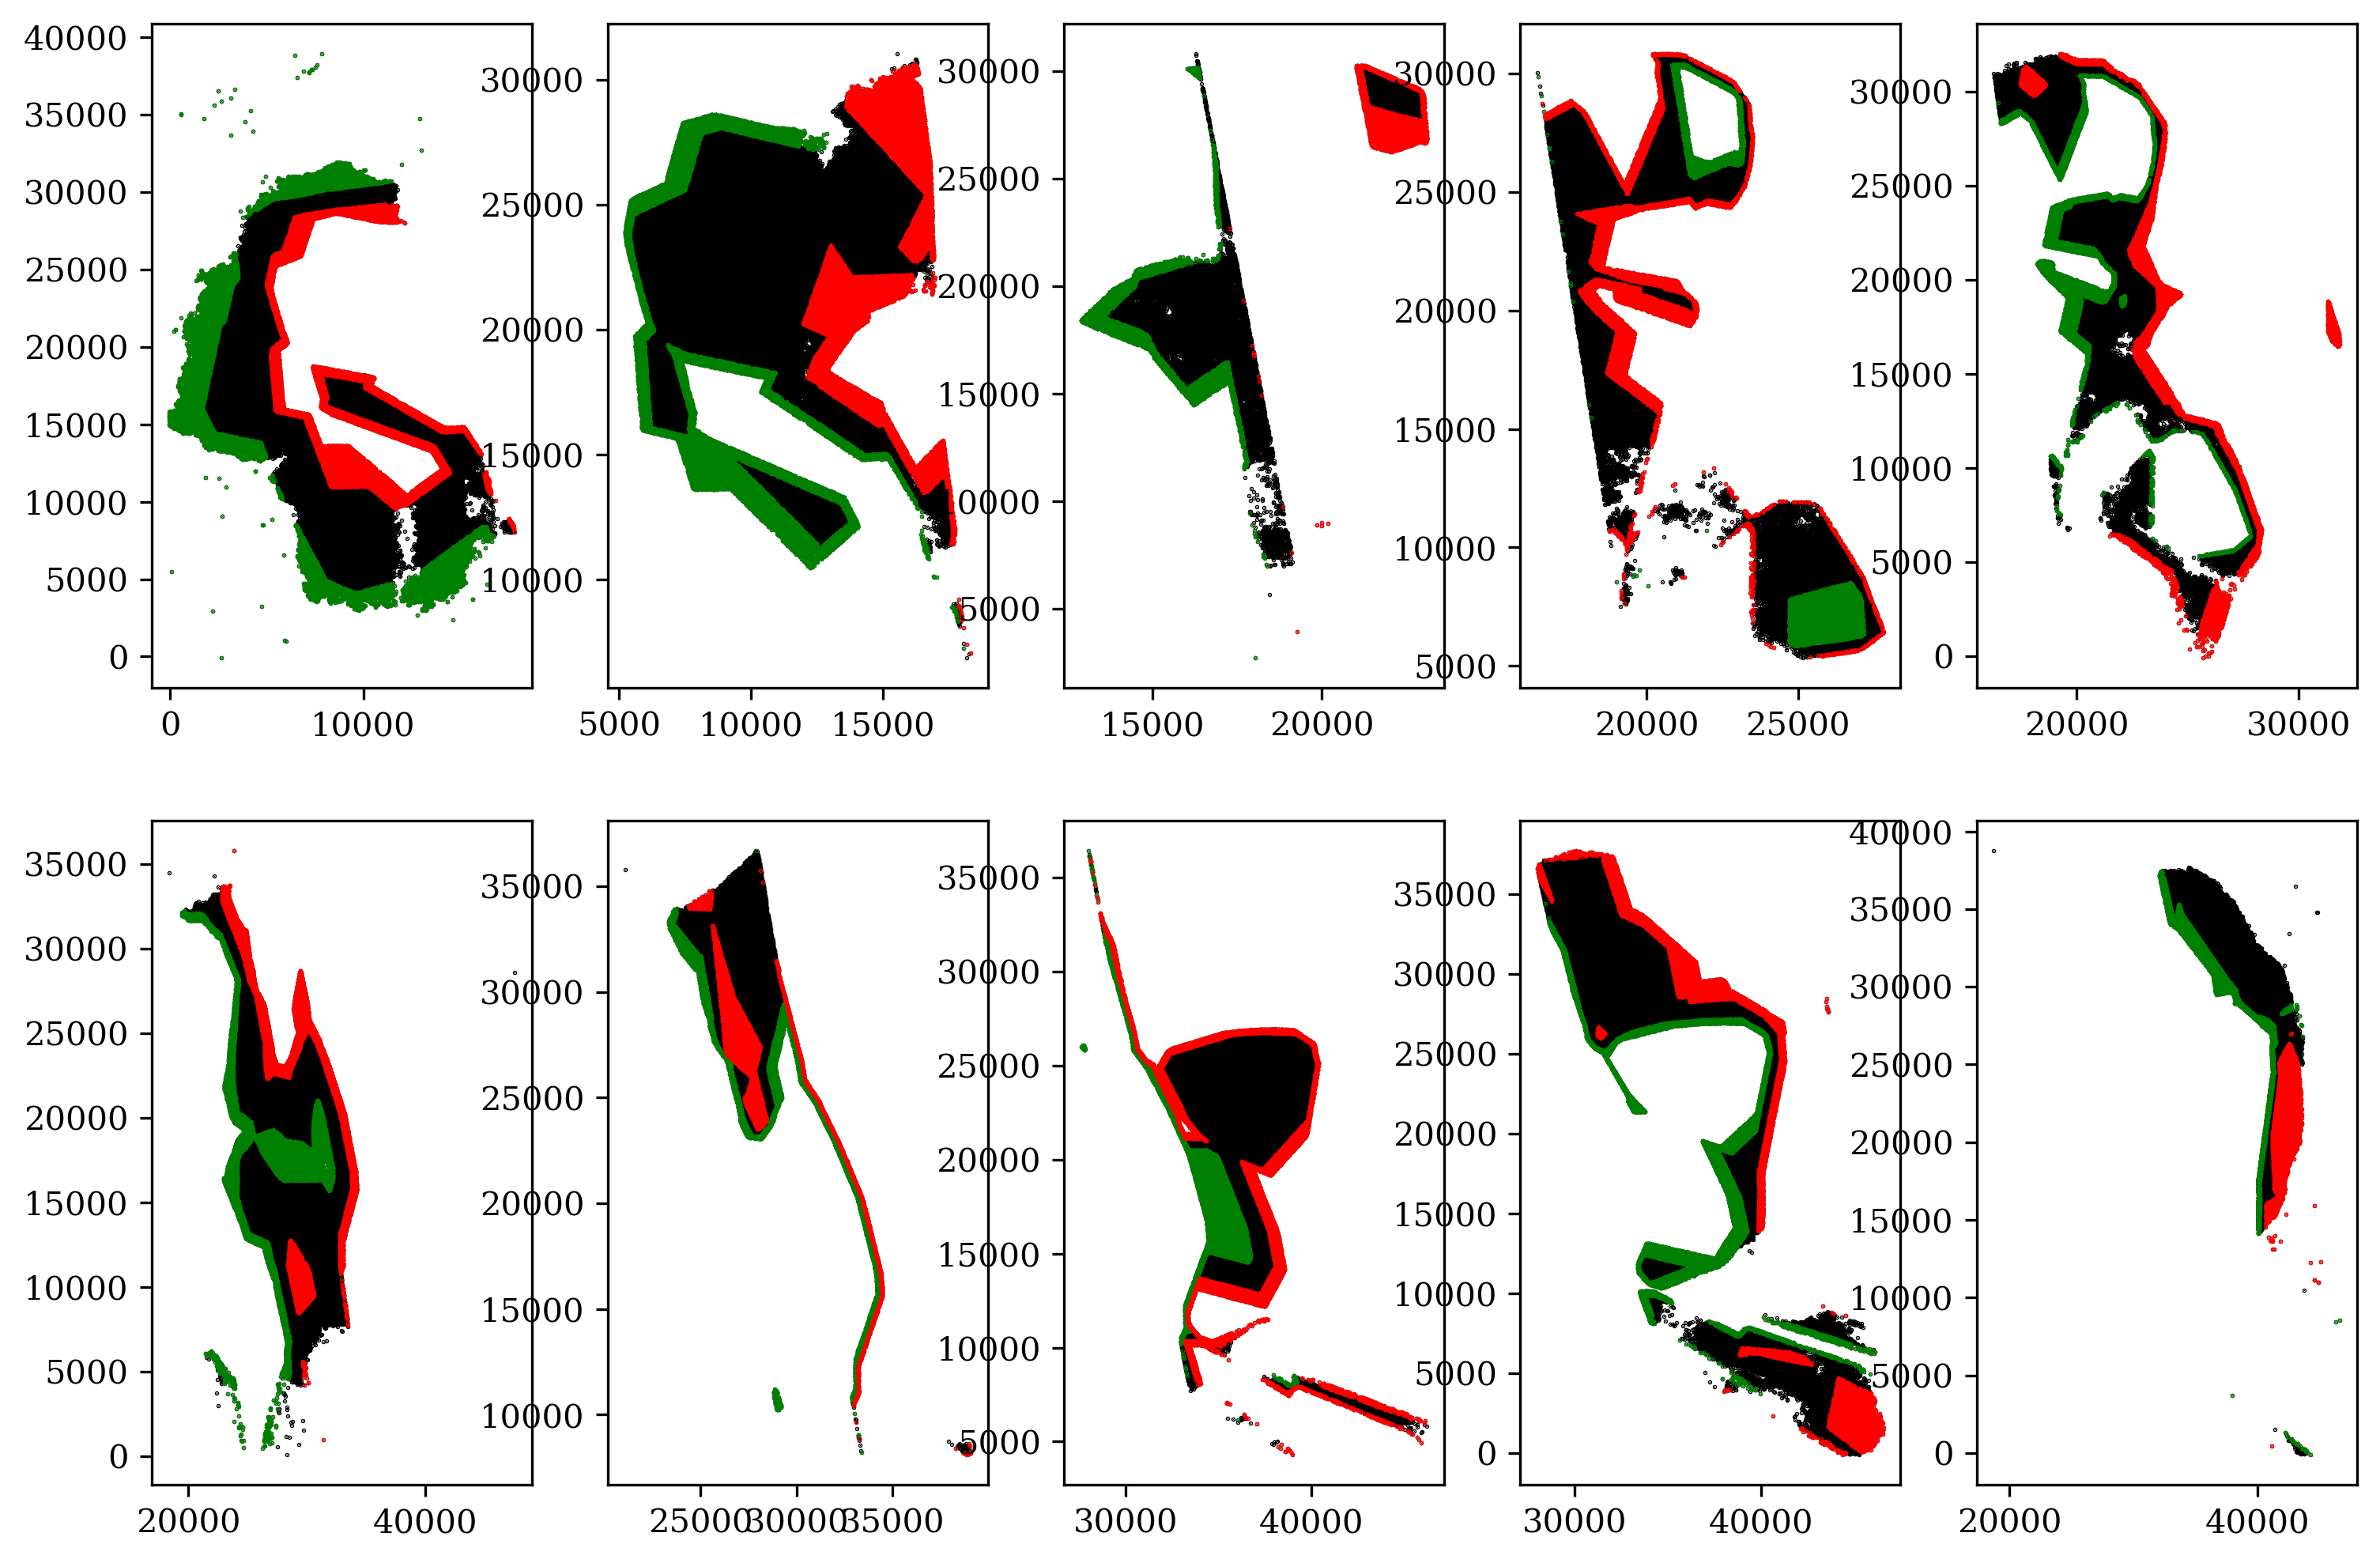

In [20]:
# VISUALIZATION
gaston_isodepth, scaling_factors = isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, num_domains=num_layers, scale_factor=0.1625, 
                                                                    visualize=True, figsize=(12, 8), num_rows=2, return_scaling_factors=True, s=0.1)

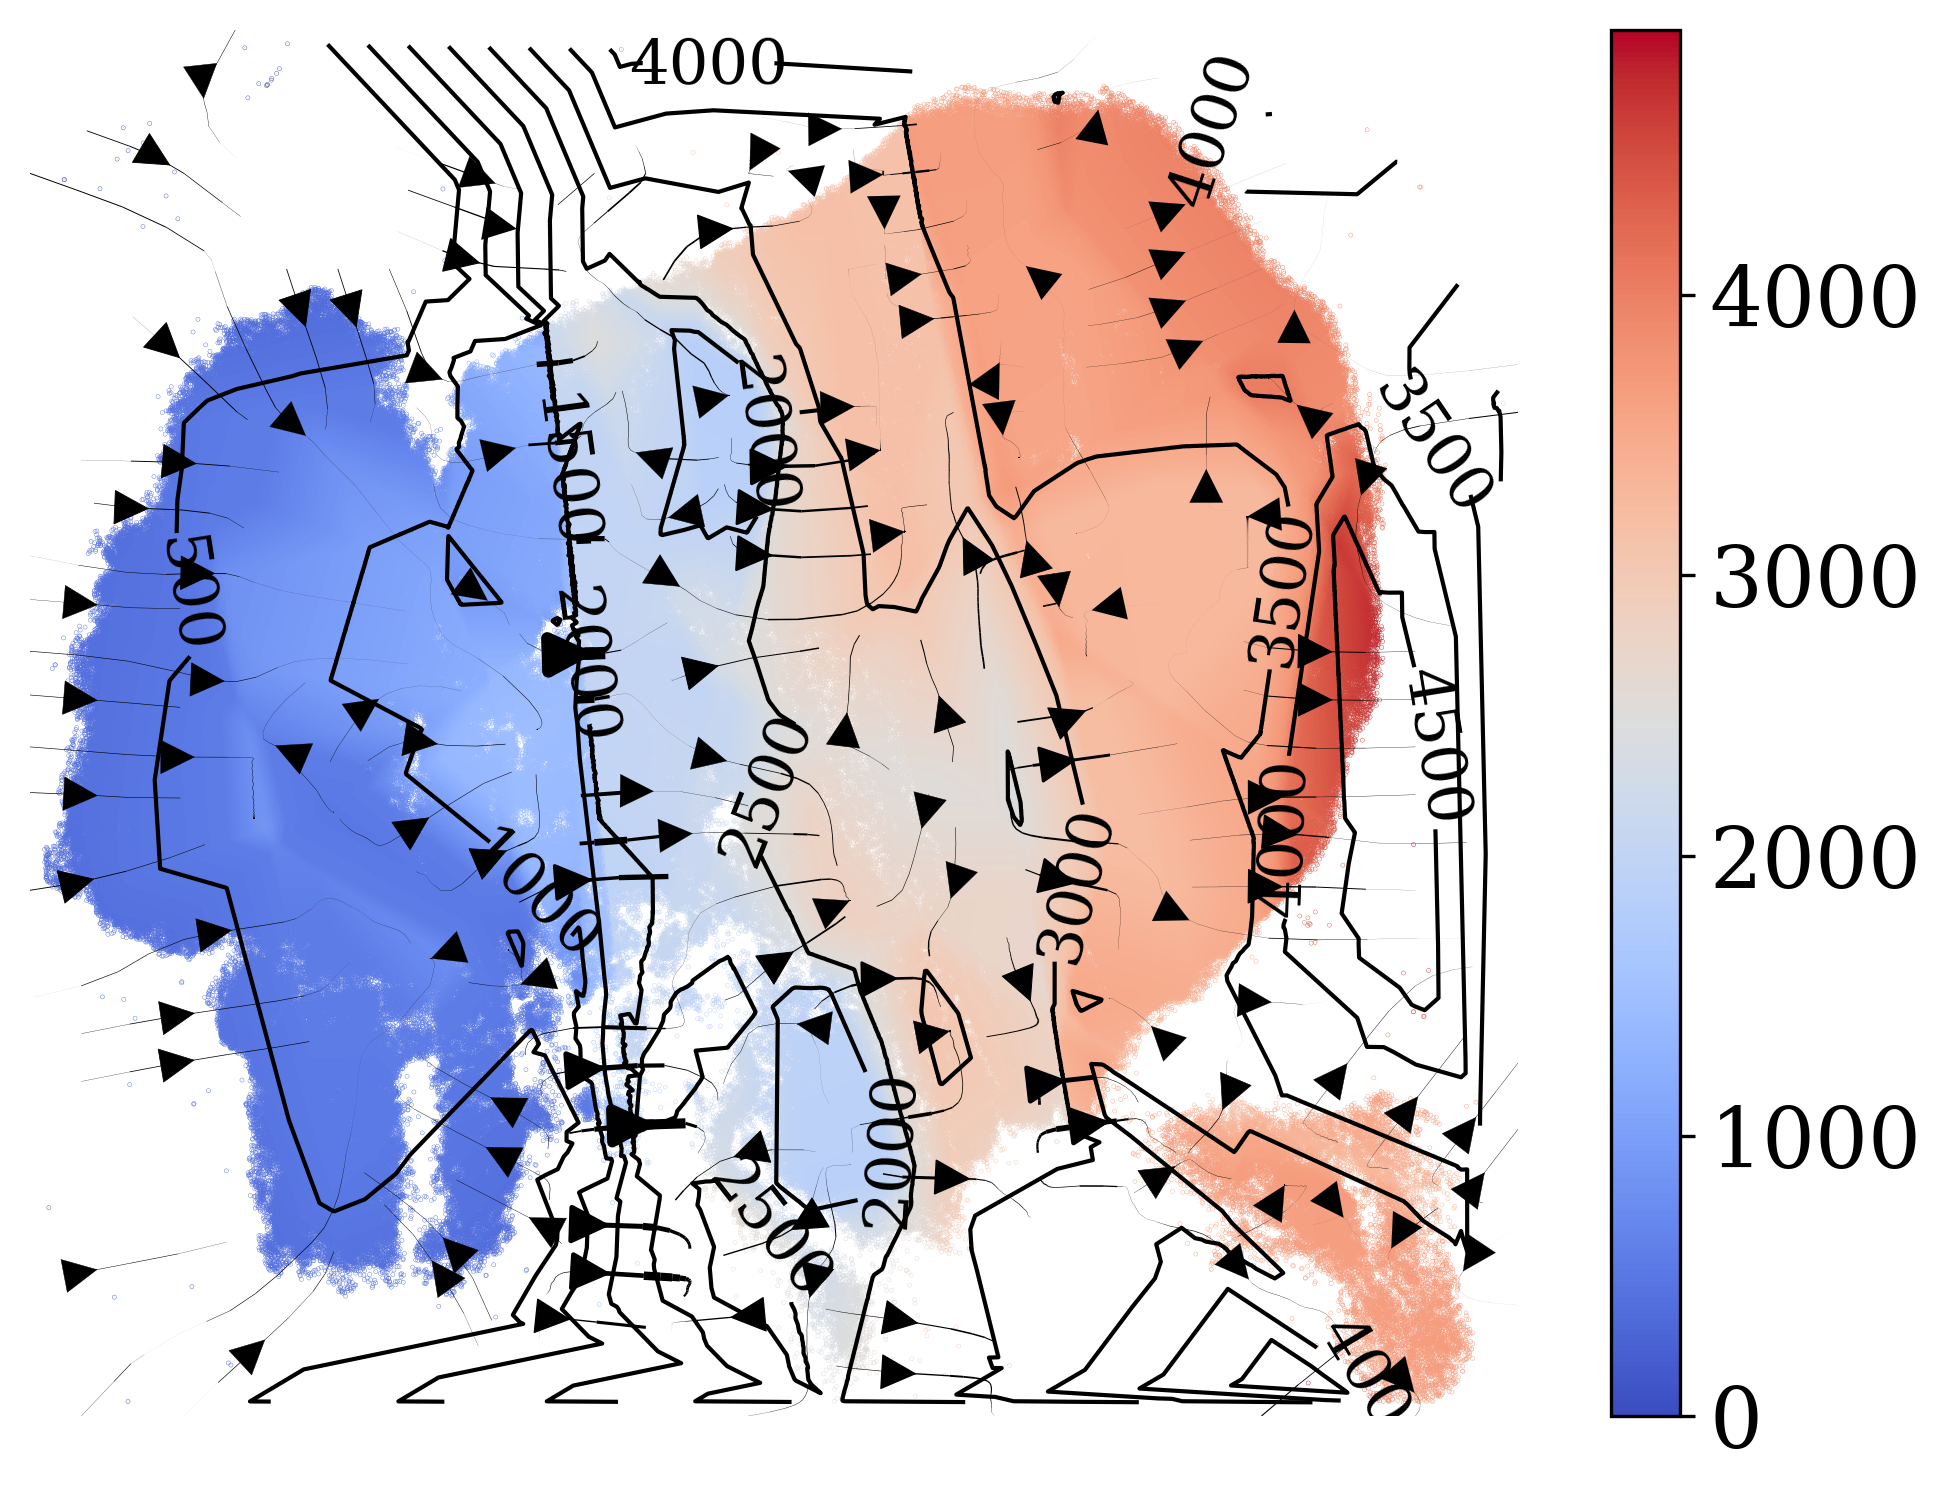

In [21]:
# VISUALIZATION
show_streamlines=True
cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, 
                               figsize=(8, 6), streamlines=show_streamlines, s=0.01,
                            #    scaling_factors=scaling_factors,
                               gaston_labels_for_scaling=gaston_labels,
                               streamlines_lw=2, contour_levels=10, 
                               cbar_fs=20, contour_fs=15)

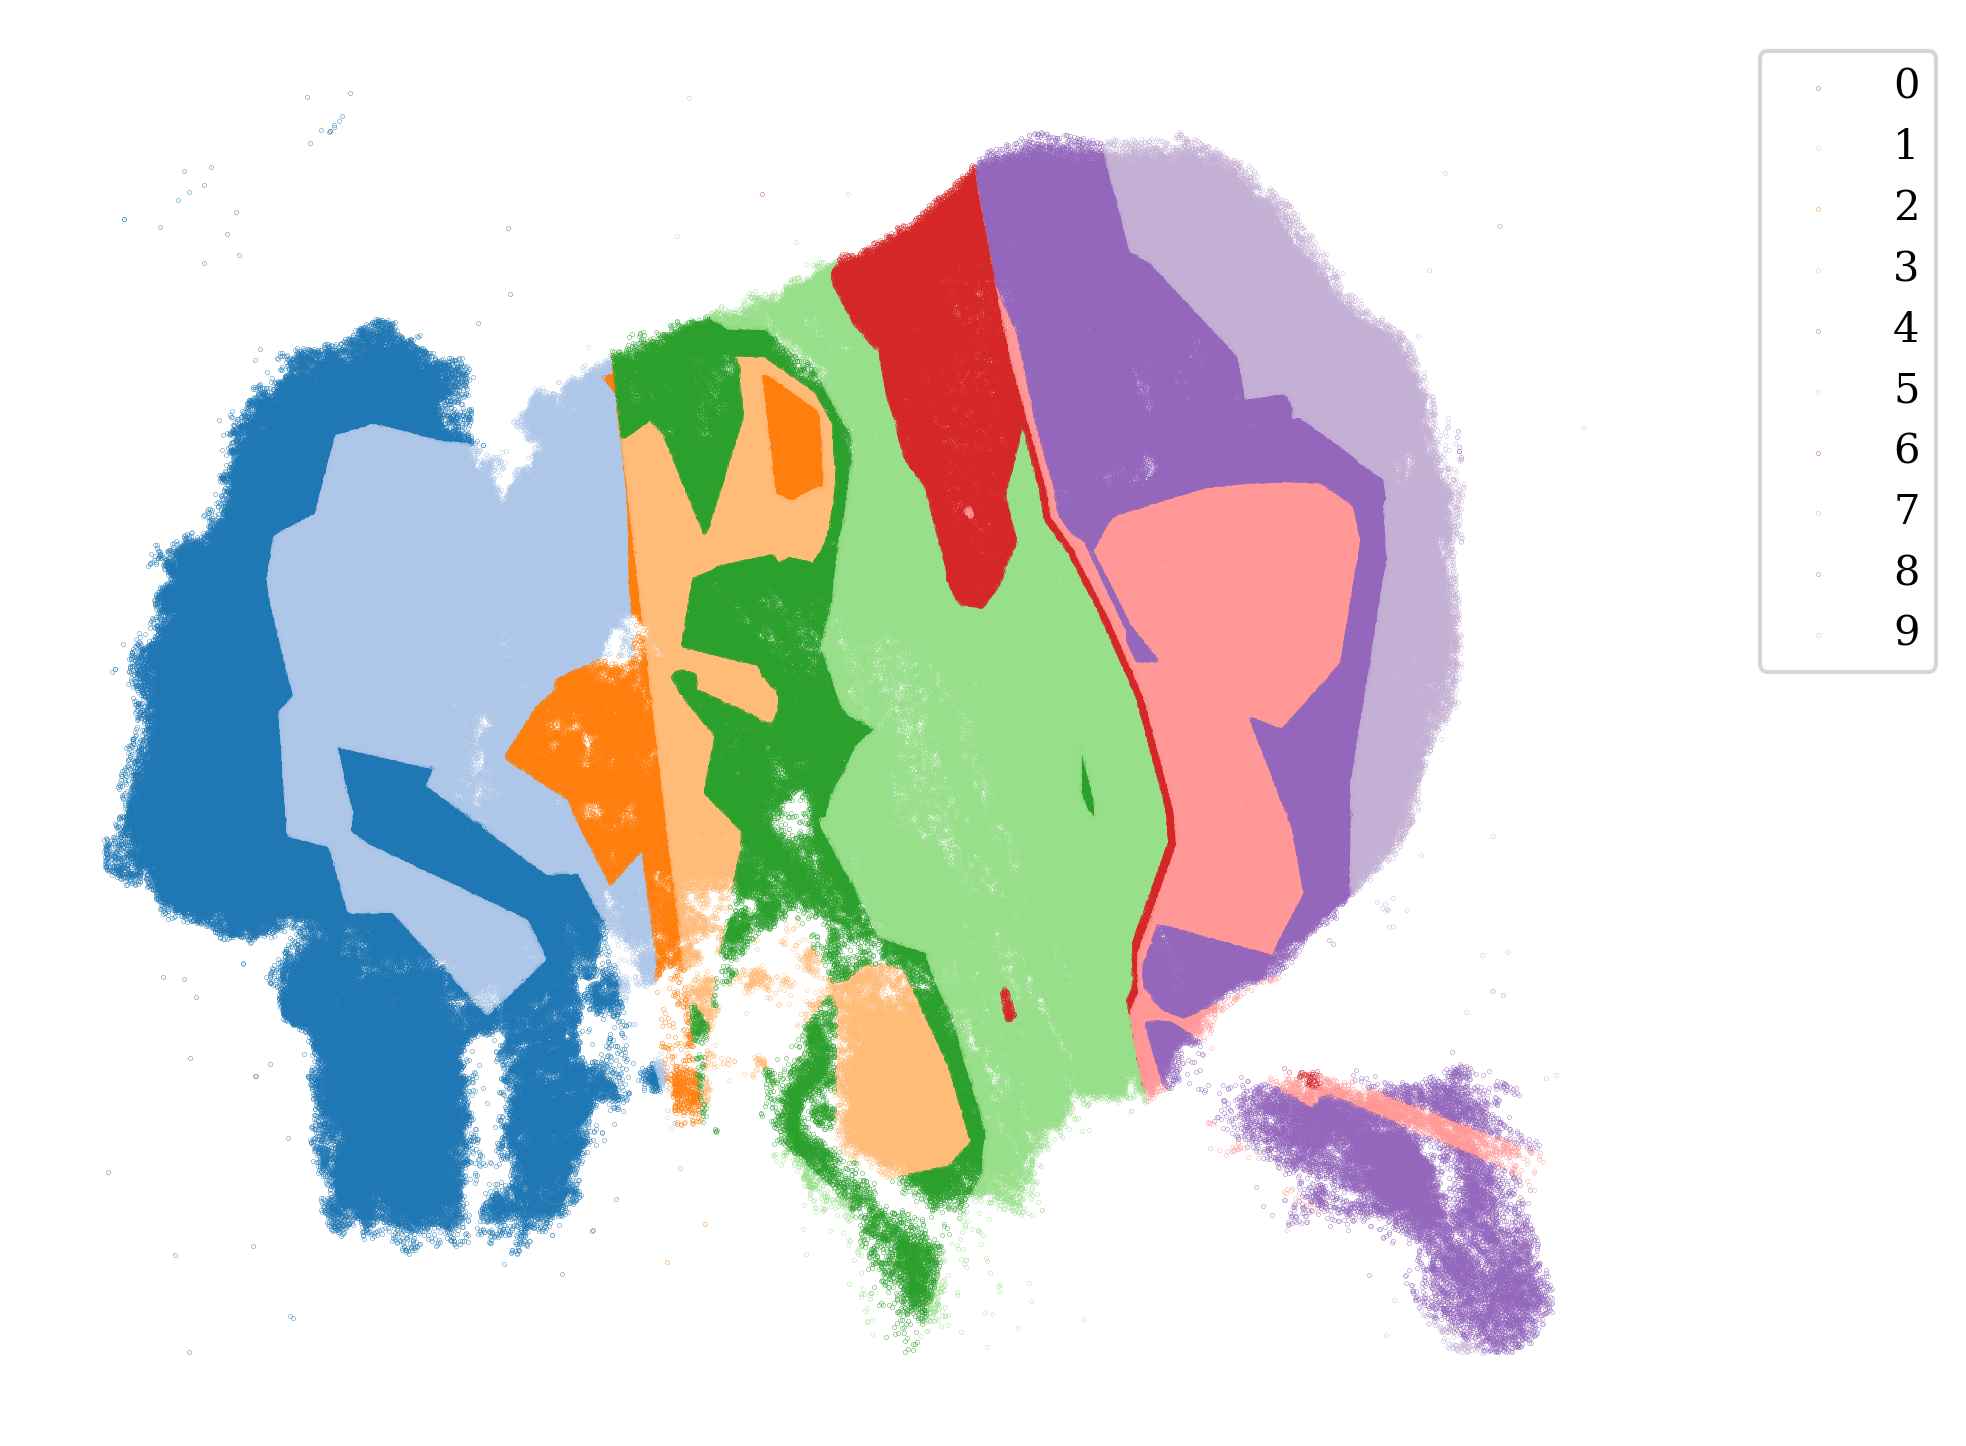

In [22]:
# WITH VISUALIZATION
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(7, 6), s=0.01, lgd=True, color_palette=plt.cm.tab20, bbox_to_anchor=(1.05,1))

In [23]:
num_layers = 20 # CHANGE FOR YOUR APPLICATION (use number of layers from above)
gaston_isodepth, gaston_labels = dp_related.get_isodepth_labels(gaston_model, A, S, num_layers)

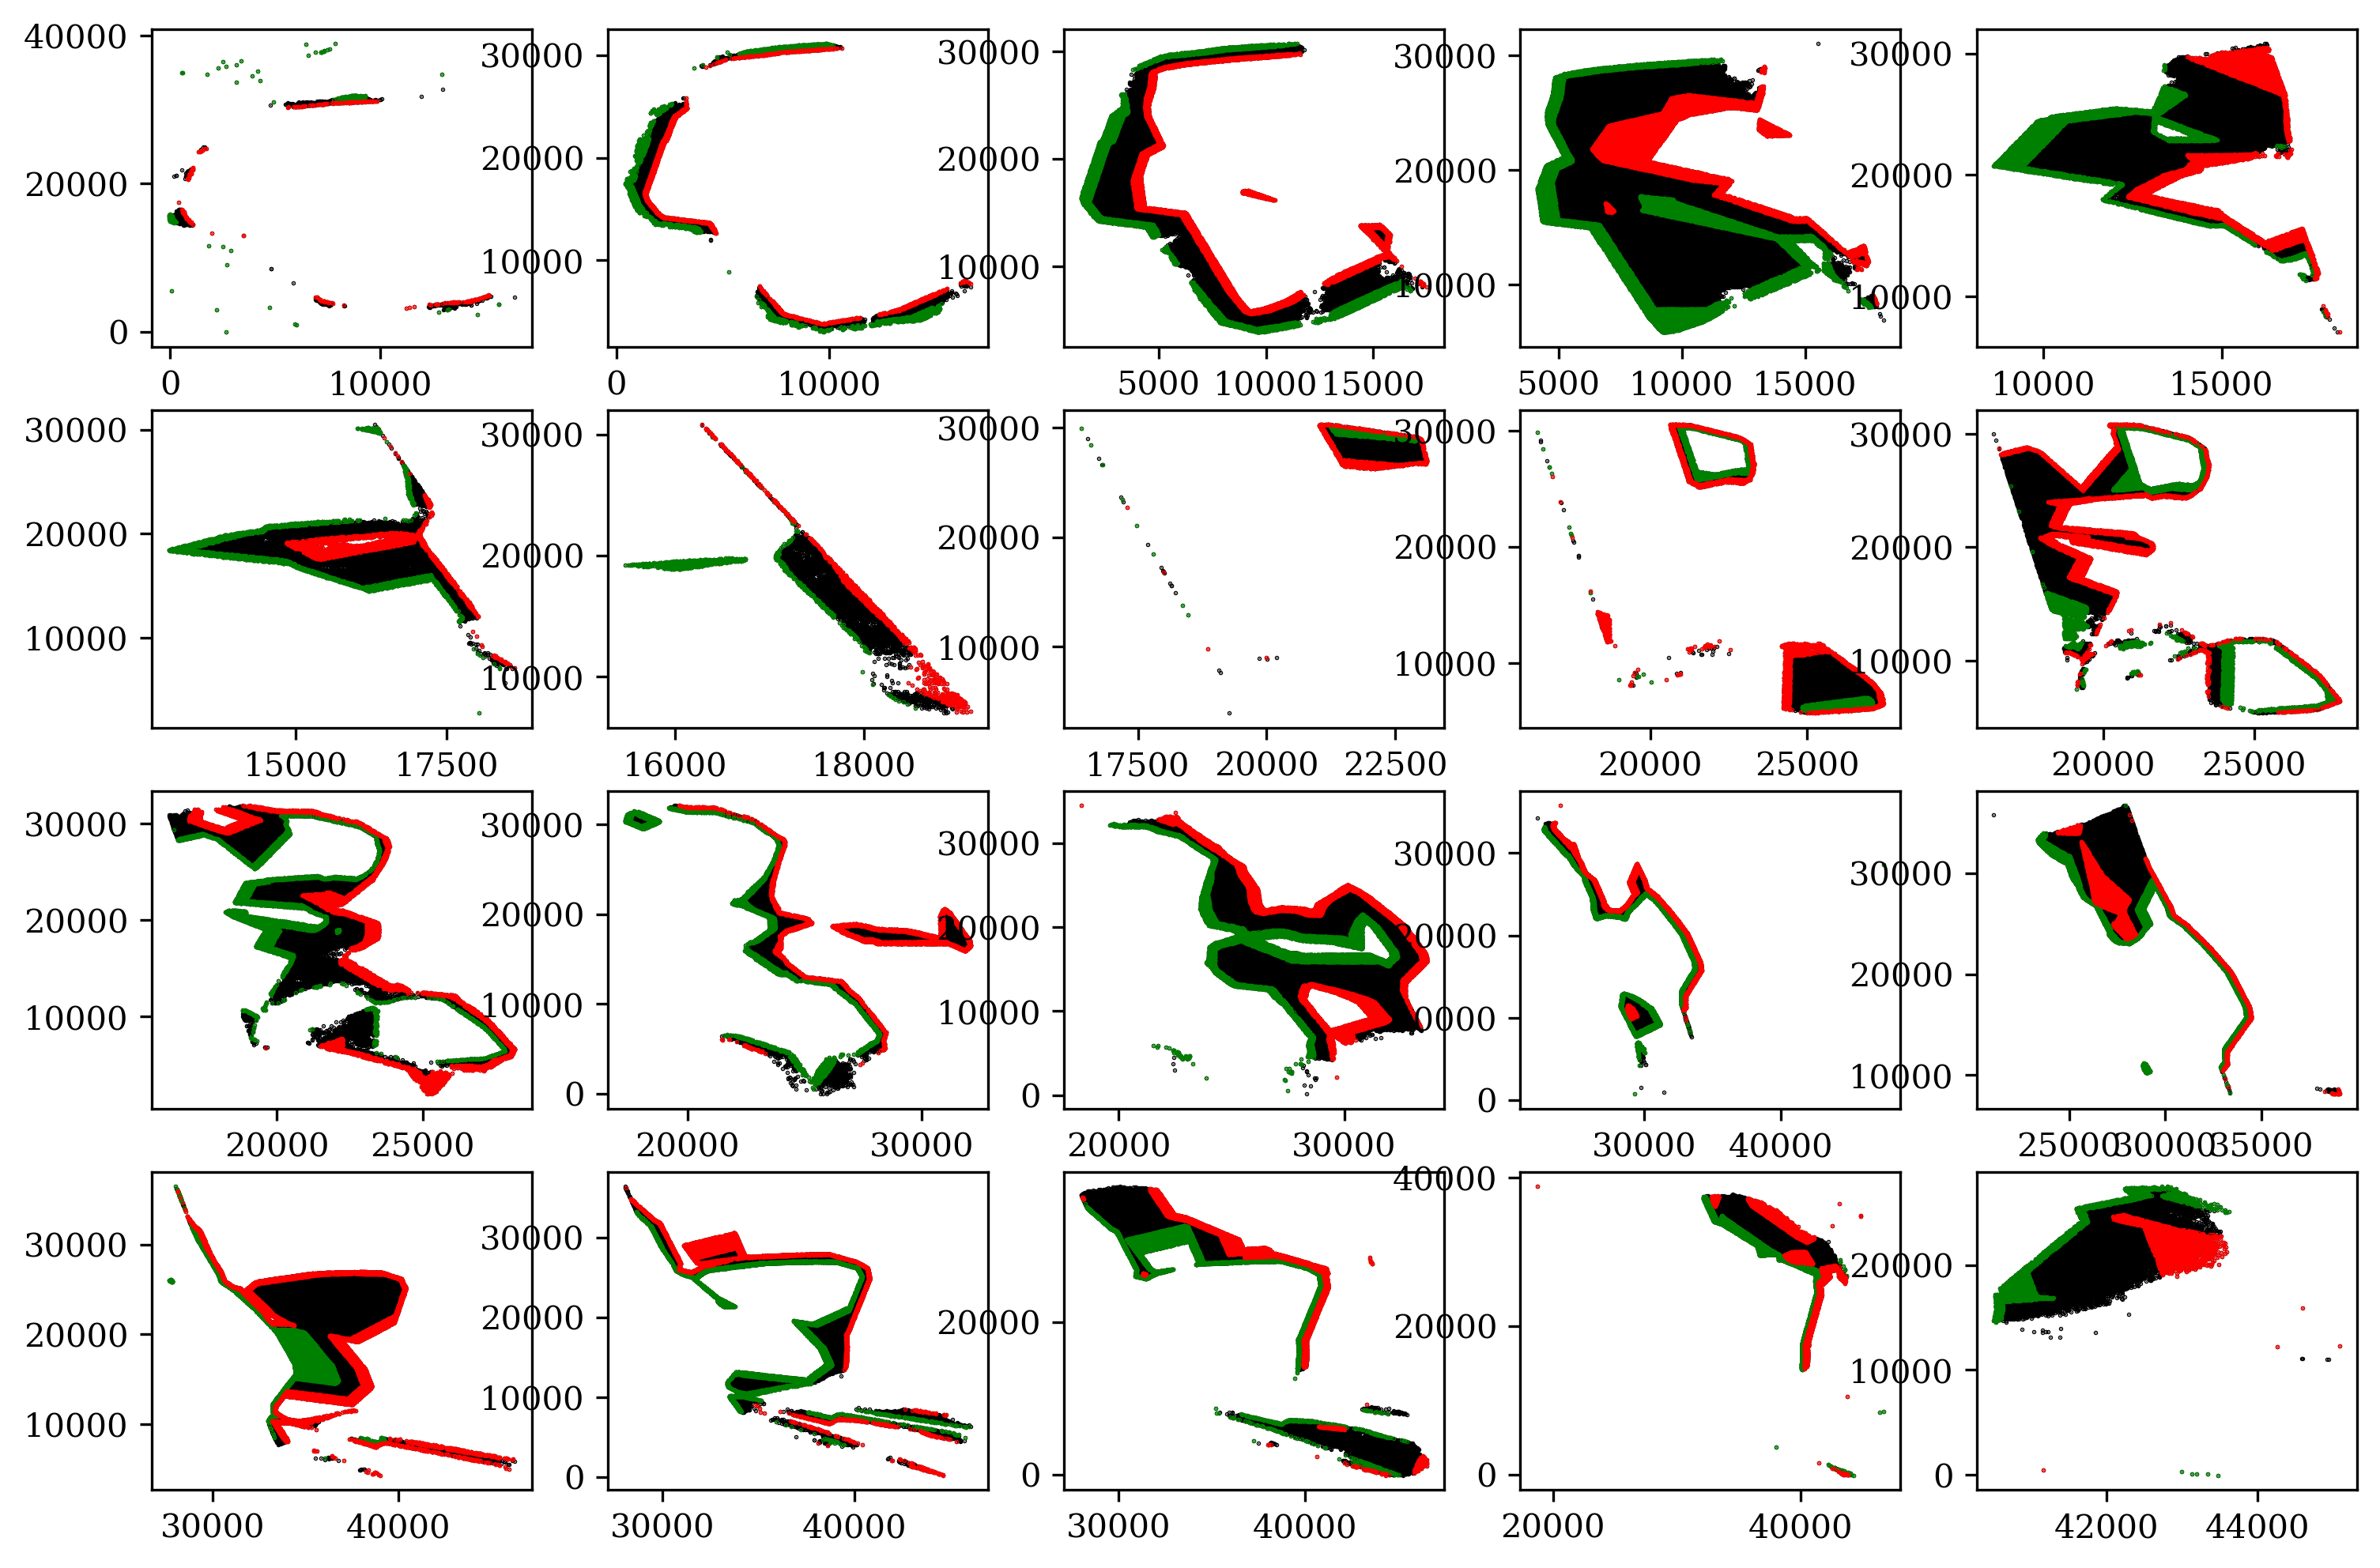

In [24]:
# VISUALIZATION
gaston_isodepth, scaling_factors = isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, num_domains=num_layers, scale_factor=0.1625, 
                                                                    visualize=True, figsize=(12, 8), num_rows=4, return_scaling_factors=True, s=0.1)

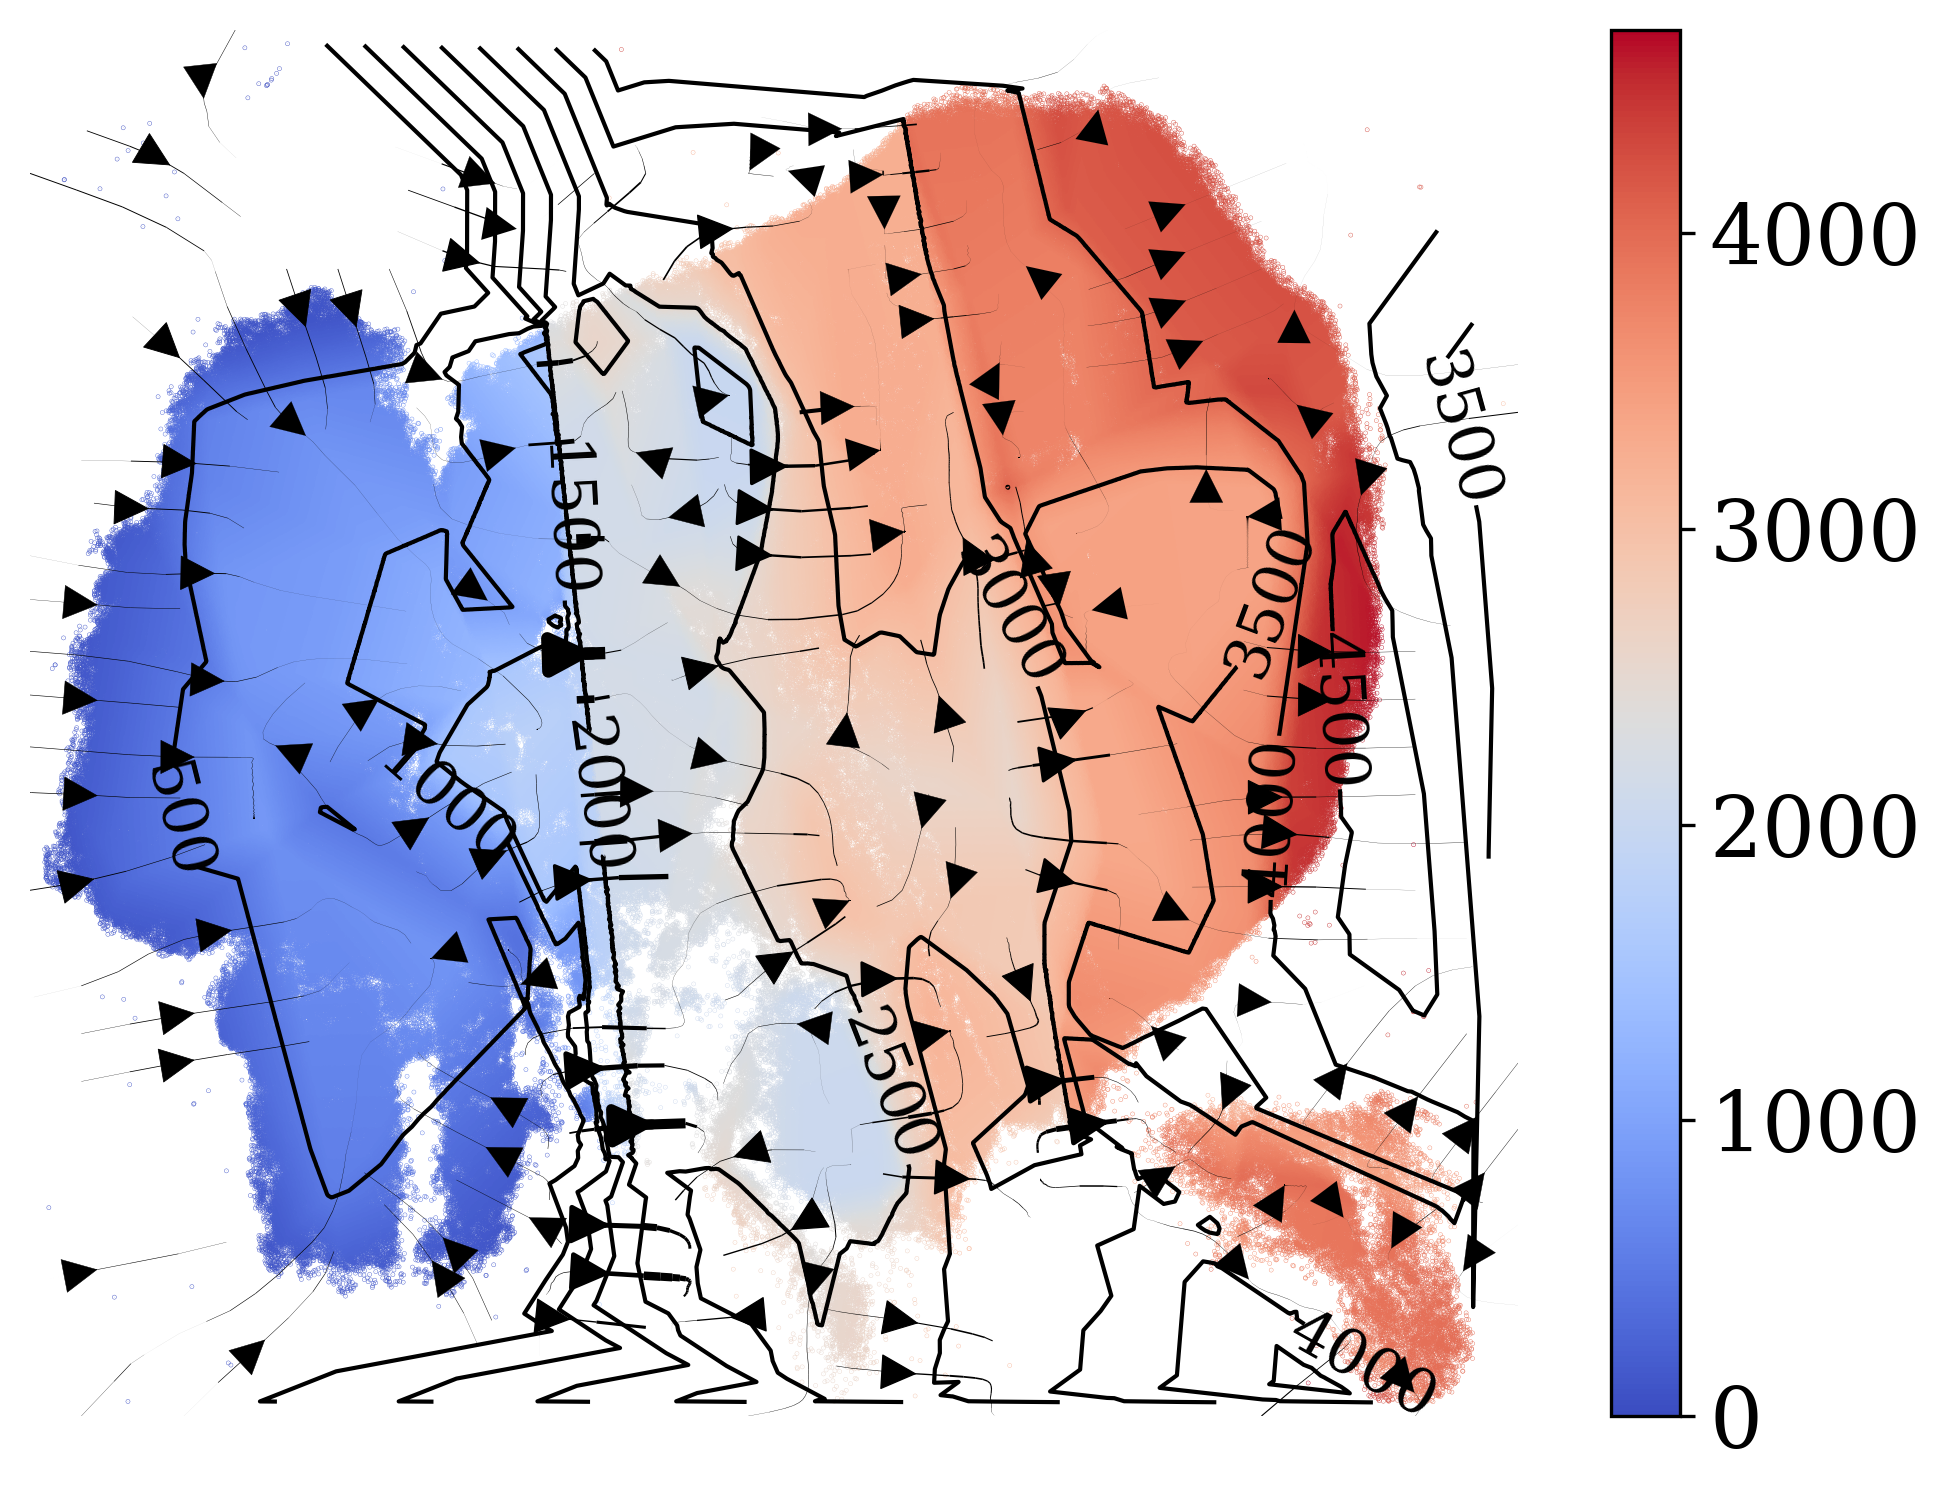

In [25]:
# VISUALIZATION
show_streamlines=True
cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, 
                               figsize=(8, 6), streamlines=show_streamlines, s=0.01,
                            #    scaling_factors=scaling_factors,
                               gaston_labels_for_scaling=gaston_labels,
                               streamlines_lw=2, contour_levels=10, 
                               cbar_fs=20, contour_fs=15)

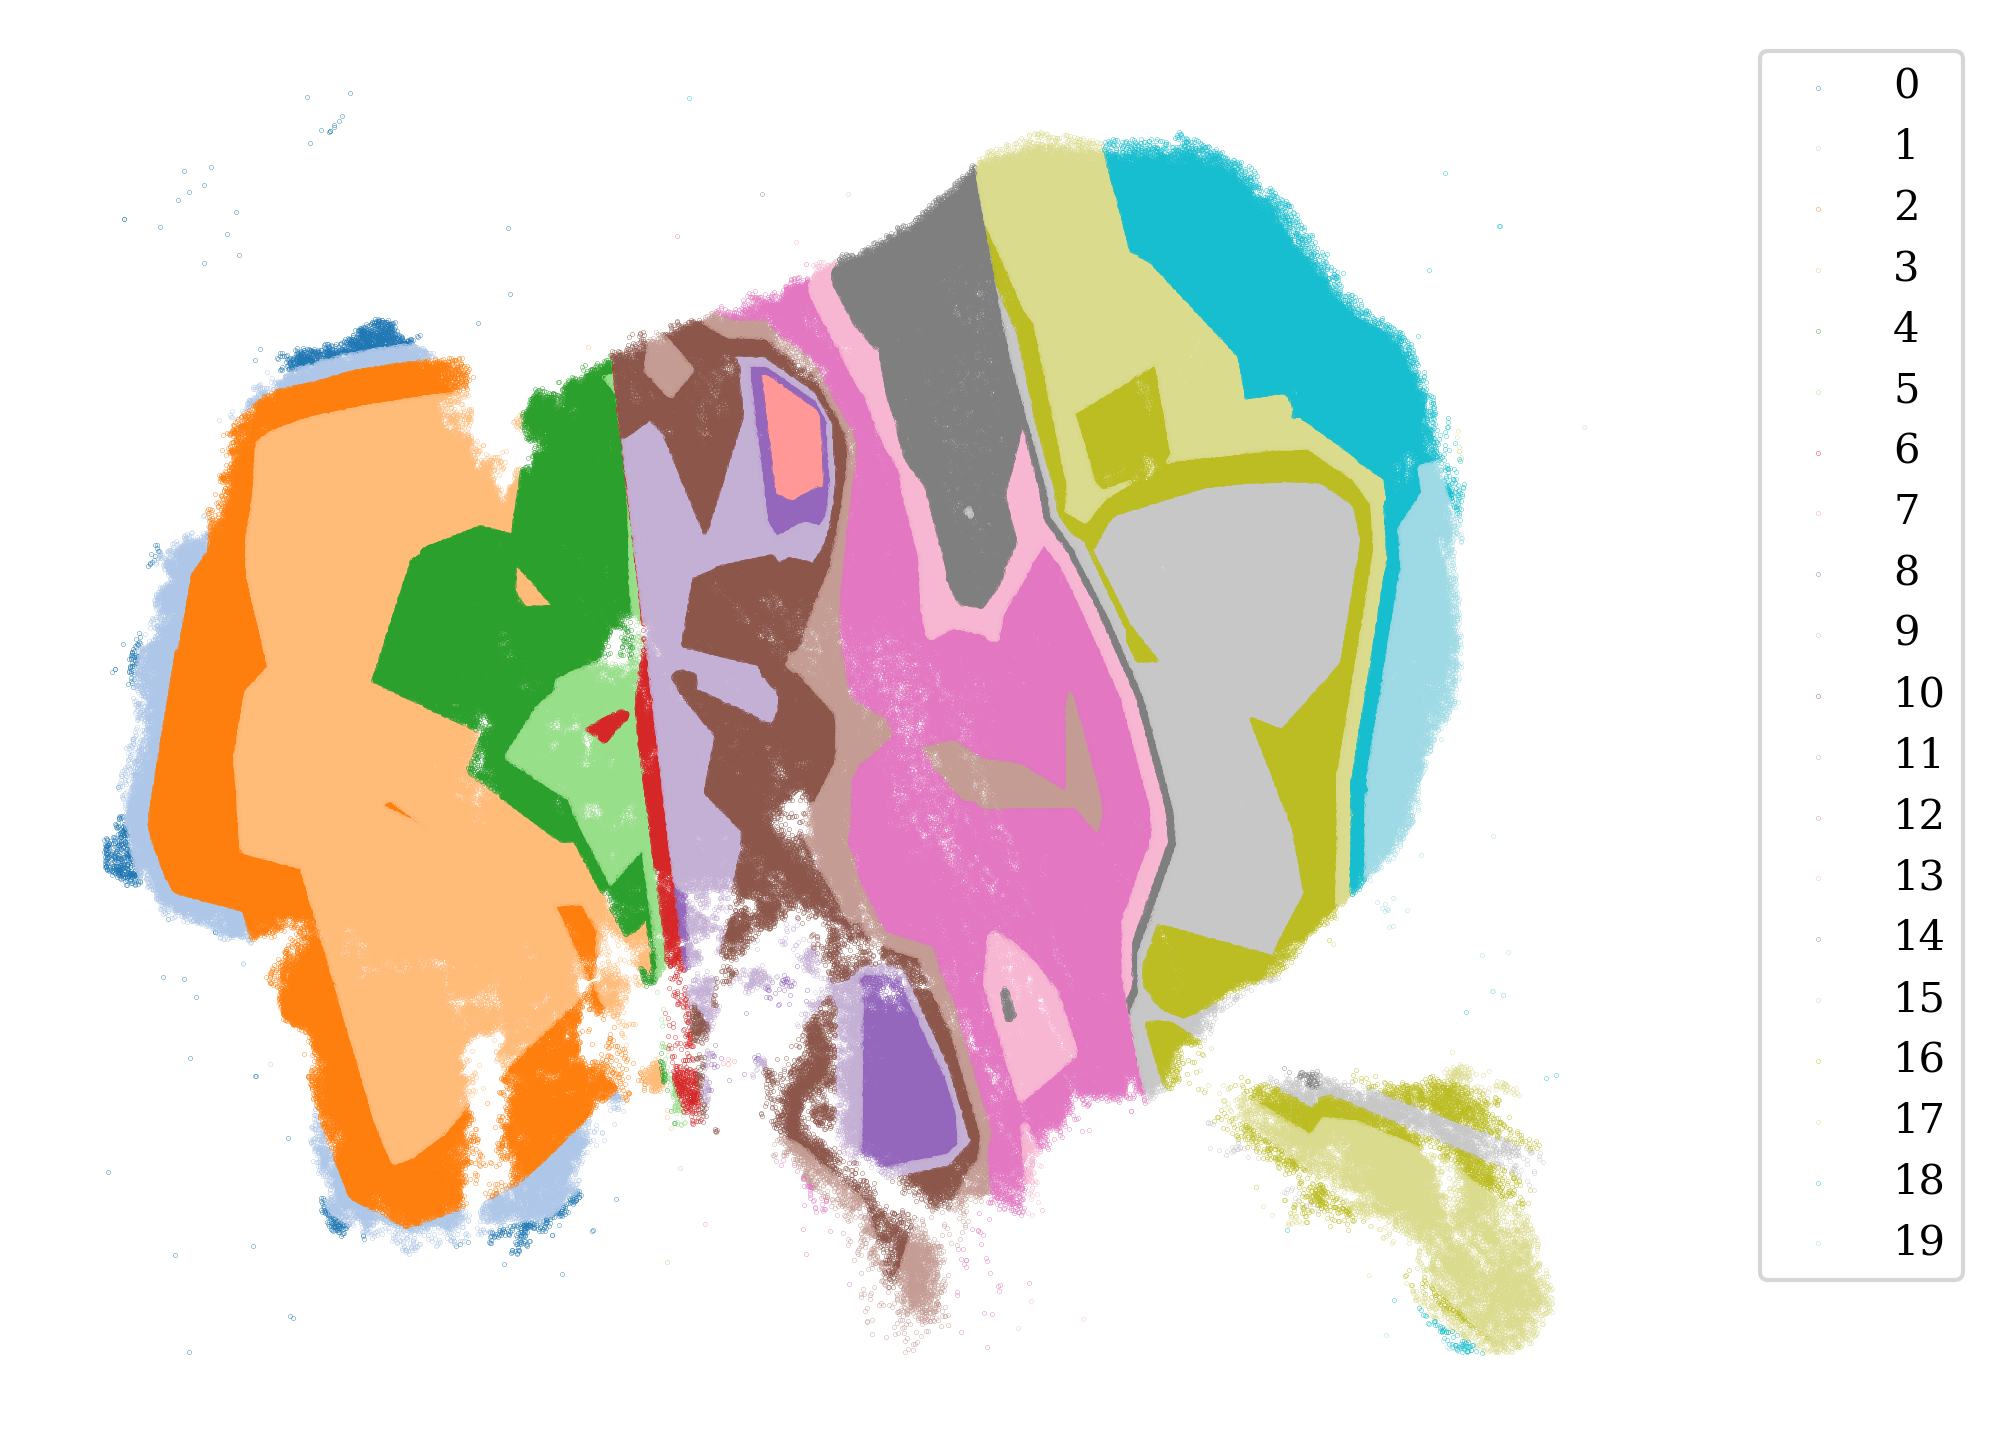

In [26]:
# WITH VISUALIZATION
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(7, 6), s=0.01, lgd=True, color_palette=plt.cm.tab20, bbox_to_anchor=(1.05,1))

## cell types vs isodepth

In [27]:
# cell_type_df = process_NN_output.create_cell_type_df(adata.obs.type)

# # Check the number of unique domains
# num_domains = len(np.unique(gaston_labels))
# print(f"Number of unique domains: {num_domains}")

# # Ensure num_bins_per_domain has the correct number of elements
# # num_bins_per_domain = [7, 10, 7, 7, 10, 10]  # Example for 4 domains

# # If num_domains is dynamic, use this instead:
# num_bins_per_domain = [10] * num_domains  # Default value for all domains

# # Plot cell type proportions
# plot_cell_types.plot_ct_props(
#     cell_type_df, gaston_labels, gaston_isodepth, 
#     num_bins_per_domain=num_bins_per_domain, ct_colors=None,
#     include_lgd=True, figsize=(15, 7), ticksize=30, width1=8, width2=2, 
#     domain_ct_threshold=0.7
# )

# # Add labels
# plt.xlabel('Isodepth (µm)', fontsize=40)
# plt.ylabel('Cell type proportion', fontsize=40)

## spatially varying gene analysis

In [28]:
# # Cell types for which to compute cell type-specific expression functions.
# # ct_list=[] # USE THIS EITHER: (1) for speed if you don't care about cell type specific effects or (2) you don't have cell type dict
# ct_list=plot_cell_types.domain_cts_svg(cell_type_df, gaston_labels, gaston_isodepth, domain_ct_threshold=0.7, num_bins_per_domain=[10]*num_domains)

# print(f'Cell types to compute expression functions for: {ct_list}')

# # if you want to get rid of warnings
# import warnings
# warnings.filterwarnings("ignore")

# # Piecewise linear fit parameters
# t=0.1 # set slope=0 if LLR p-value > 0.1
# umi_threshold=500 # only compute fit for genes with total UMI > 500
# zero_fit_threshold=0 # xenium is not sparse so can compute for all cell types

# pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth, 
#                                           cell_type_df, ct_list, zero_fit_threshold=zero_fit_threshold,
#                                         t=t,umi_threshold=umi_threshold,
#                                        isodepth_mult_factor=0.1) # isodepth_mult_factor for stability, if range of isodepth values is too large

In [29]:
# print(f"counts_mat shape: {counts_mat.shape}")
# print(f"gaston_labels shape: {gaston_labels.shape}")
# print(f"cell_type_df shape: {cell_type_df.shape}")
# print(f"gene_labels shape: {gene_labels.shape}")

In [30]:
# binning_output=binning_and_plotting.bin_data(
#     counts_mat, gaston_labels, gaston_isodepth, 
#     cell_type_df, gene_labels, num_bins_per_domain=[10]*num_domains, umi_threshold=umi_threshold)
# domain_cts=plot_cell_types.get_domain_cts(binning_output, 0.7)

In [31]:
# discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output)
# cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output, q=0.9)
# cont_genes_ct=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output, ct_attributable=True, domain_cts=domain_cts,q=0.9)
# cont_genes_ct

In [32]:
# domain_cts

In [33]:
# gene_name='HBV'
# print(f'gene {gene_name}, continuous gradients {cont_genes_ct[gene_name]}')

# binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
#                                         binning_output, cell_type_list=None, pt_size=50, colors=None, 
#                                         linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
#                                        domain_boundary_plotting=True)
# # plt.ylim((1.5,8.5))

In [34]:
# # show cell type-specific functions in domain 1 (granule)
# domain=2
# cts=domain_cts[domain]
# #remove stromal
# # cts=[x for x in cts if x != 'Tumor']

# binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
#                                         cell_type_list=cts,ct_colors=None, spot_threshold=0.05, pt_size=60, 
#                                         colors=None, linear_fit=True, domain_list=[domain],ticksize=15, 
#                                         figsize=(1.5,2.5), offset=10**6, lw=3, alpha=0.8,show_lgd=True)
# cts_list=' '.join(map(str, cts))
# plt.title(f'{cts_list} only')